<a href="https://colab.research.google.com/github/JiayingCarrie/Numerical_Model_TCSPC_Raman_Lidar/blob/main/8_7_7_Numerical_model_TCSPC_Raman_LiDAR_V5_(H2%26N2_260121%2CCryLaS_10_965m%2C600s%3Bpublish)_LOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCSPC Raman LiDAR Model – Preface

This Google Colaboratory notebook implements a numerical model for **Time-Correlated Single-Photon Counting (TCSPC)** signal processing, specifically applied to **Raman LiDAR** for the stand-off detection of hydrogen ($H_2$).
Developed by *Andrew Lockwood, Jiaying Wang, and Charles N. Ironside* (*Curtin University*), the model supports the analysis and fitting of experimental data acquired from laboratory prototype TCSPC Raman LiDAR systems.

**Key Features and Functionality:**

The notebook provides a detailed framework for simulating a TCSPC Raman LiDAR system, incorporating essential physical phenomena and noise sources that influence photon detection and signal interpretation.

**1. Lidar Equation Implementation**

A photon-based form of the LiDAR equation is used to model backscattered light, accounting for:

*   Pump laser parameters (wavelength, pulse width, energy, repetition rate)
*   LiDAR system parameters (time resolution, integration time, optical filter bandwidth, system efficiency, dark count rate, receiver aperture, propagation range, and channel crosstalk)

**2. Raman and Rayleigh Scattering**

The model distinguishes between Raman scattering (with Stokes shift) and Rayleigh scattering (at the pump wavelength). Dedicated subroutines calculate the expected mean photon returns for different gas species (e.g., $H_2$, $N_2$, $O_2$) based on their respective scattering cross-sections.

**3. Poissonian Photon-Counting Statistics**

Photon detection is modelled using Poisson statistics, which determine the probability of detecting one or more photons—or no photons—given the expected mean photon number per time step. This approach enables realistic simulation of single-photon events in TCSPC detection.

**4. Noise Source Modelling**

The principal sources of detection noise are explicitly included:

*   **Dark counts** — intrinsic detector noise
*   **Sky background** — simulated using solar spectral irradiance data to account for ambient light
*   **Crosstalk effects** — including Rayleigh and $H_2O$ Raman crosstalk, modelling photons that leak into the $H_2$ Raman detection channel, which is essential for accurate hydrogen detection

**5. Gas Plume Simulation**

A **3D anisotropic Gaussian diffusion plume** enables the definition and visualisation of hydrogen gas concentration profiles as a function of distance, with adjustable leak rate, anisotropy, and background concentration.

**TCSPC Signal Processing Framework:**

The temporal and statistical aspects of photon detection are simulated using a nested loop structure:

*   **Outer loop** — iterates over laser pulses
*   **Inner loop** — processes photon detection events across time steps that are mapped to distance steps

The framework includes:

*   **Pulse spread uncertainty** — Monte-Carlo treatment of temporal jitter arising from the finite laser pulse duration
*   **Detector dead time** — modelling detector recovery time following a photon detection event

**Purpose**

This notebook serves as a comprehensive and physically grounded tool for researchers and engineers developing or analysing **TCSPC Raman LiDAR** systems.
It provides a flexible platform for:

*   Understanding photon-counting signal characteristics
*   Optimising system parameters
*   Fitting and interpreting experimental data for stand-off gas detection

# Section 1 Introduction
---
The purpose of this notebook is to numerically model Time-Correlated Single-Photon Counting (TCSPC) signal processing for a Raman LiDAR system.

For background and related studies, see for example:

> Stothard, D.J., Warden, M.S., Spesyvtsev, R., Kelly, E., Leck, J., Allen, A., Squire, J., Hepworth, S., Malone, S., Tunney, J. and Allison, F., 2022, May. Long-range, range-resolved detection of H2 using single-photon ‘quantum’Raman: a condition monitoring tool for long-term storage of nuclear materials. In Chemical, Biological, Radiological, Nuclear, and Explosives (CBRNE) Sensing XXIII (p. PC1211608). SPIE. https://doi.org/10.1117/12.2621423

See also:

> Gimmestad, G.G. and Roberts, D.W., 2023. Lidar engineering: introduction to basic principles. Cambridge University Press.

**User Input Parameters:**

The program requires the following user-defined inputs to accurately model the Raman LiDAR system.

**1. Laser**

These parameters define the characteristics of the laser source driving the Raman scattering process:

*   **Laser wavelength** [nm]
*   **Laser pulse width** [ns]
*   **Laser pulse energy** [µJ]
*   **Laser repetition rate** [Hz]

**2. LiDAR & Collection Optics**

These parameters describe the performance and efficiency of the receiver optics and detection system:

*   **LiDAR constant** — (0–1), LiDAR constant (detector and collection optics efficiencies)
*   **Crosstalk** — estimate of photon leakage between detection channels
*   **Detector dark count rate** [counts/s or s⁻¹]

**3. Signal processing & Timming**

These parameters define how the TCSPC system records and processes photon detection events:

*   **Signal processing & timming** [s]
*   **detector dead time** [ns]
*   **Integration time** [s]
*   **Start distance** [m]
*   **Maximum measurement range** [m]


# Section 2 The TCSPC Raman LiDAR Model
---


## The LiDAR Equation (Photon)

The average number of backscattered photons returned in a Raman channel at wavelength $\lambda_R$ is given by the LiDAR equation, shown below:

$$P_B(z) = \frac{P_p\,K\,\Delta z\,A_0\,\left(\mathrm{d}\sigma/\mathrm{d}\Omega\right)\,N}{z^2}\, T_{\lambda_p}(z)\, T_{\lambda_R}(z)\, \gamma(z),$$

where

*   $P_B(z)$ is the number of backscattered photons at range $z$.
*   $z$ is the range, defined as the distance from the receiving optics to the region of interest.
*   $P_p$ is the number of pump photons per laser pulse.
*   $K$ is the LiDAR constant, which accounts for detector and collection optics efficiencies.
*   $\Delta z$ is the spatial extent of the sampled region, given by $\Delta z \approx P_w\, c$, where $P_w$ is the laser pulse width and $c$ is the speed of light.
*   $A_0$ is the cross-sectional area of the collection optics aperture.
\item $(\mathrm{d}\sigma/\mathrm{d}\Omega)$ is the Raman scattering cross-section.
*   $N$ is the molecular number concentration.
*   $T_{\lambda_p}(z)$ is the range-dependent atmospheric transmission at the pump wavelength.
*   $T_{\lambda_R}(z)$ is the range-dependent atmospheric transmission at the Raman wavelength.
*   $\gamma(z)$ is the range-dependent overlap function between the laser
beam and the receiver field of view (FOV).

## Illustration of TCSPC Raman LiDAR Operation

The figure below provides a schematic overview of the operating principle of a TCSPC Raman LiDAR system.

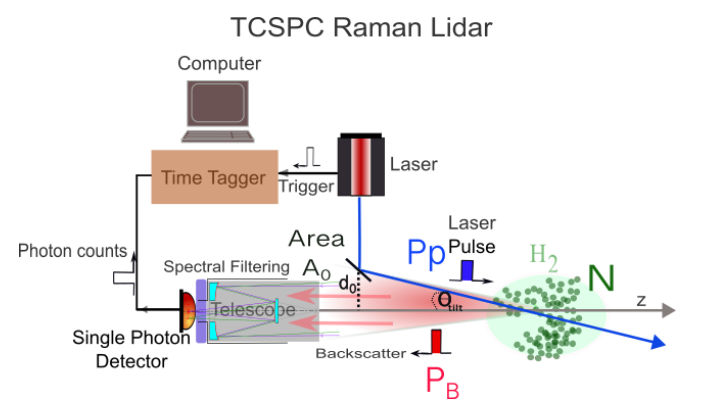

A generic schematic of a TCSPC Raman LiDAR system is shown, illustrating the selection of a single Raman channel through spectral filtering. The labels correspond to those used in the LiDAR equation. Definitions of $d_0$ and $\theta_{\mathrm{tilt}}$ are provided in the overlap function description.

## Model Flowchart

The combined TCSPC Raman LiDAR and gas plume model is implemented in a Python Jupyter notebook. The structure of the model reflects the physical processes involved in Raman backscattering and photon detection, and consists of three main components: the $H_2$ gas distribution, the $H_2$ Raman signal, and noise contributions, followed by a Monte-Carlo photon-counting simulation.

The flowchart of the model is shown below.

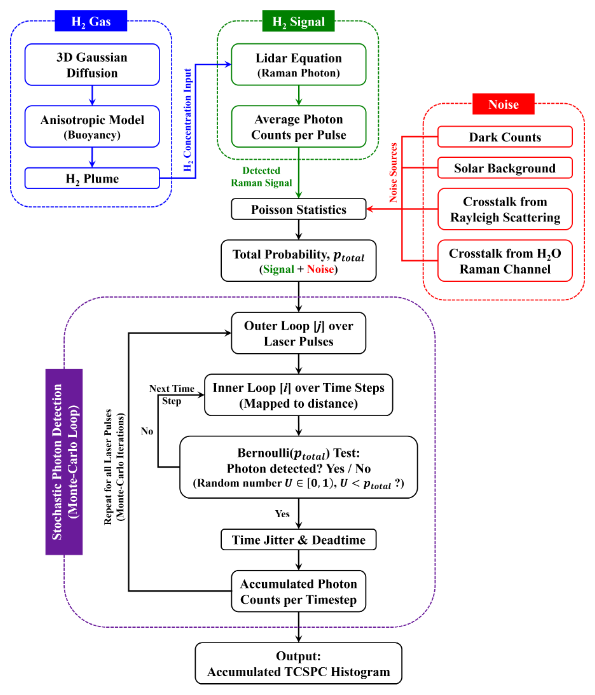

# Section 3 Required Python Packages and Functions
---

### Required Python Packages

In [ ]:
# ----------------------------
# Required Python Packages
# ----------------------------
# Set random seeds for reproducibility
import random
import numpy as np
random.seed(1234)
np.random.seed(1234)

# Basic Python and scientific packages
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy import constants
from numba import njit

# Fundamental constants
h = constants.Planck  # J⋅s, Planck constant
Pi = constants.pi
c = constants.speed_of_light  # m/s, speed of light

### Raman Lidar Function

The key parameters for $H_2$ sensing using Raman LiDAR scattering are:

*   $H_{2}$ Raman scattering cross section $(d\sigma/d\Omega)_H=7.07 \times 10^{-30} cm^2sr^{-1} @ 355~nm$ Stokes shift $4160.2~cm^{-1}$
*   $N_2$ Raman scattering cross section $(d\sigma/d\Omega)_N=2.28 \times 10^{-30} cm^2sr^{-1} @ 355~nm$ Stokes shift $2330.7~cm^{-1}$
*   $H_2O$ Raman scattering cross-section $(d\sigma/d\Omega)_O = 6.34 \times 10^{-30} cm^2sr^{-1} @355nm$ Stokes shift $3651.7~cm^{-1}$

These values derived from:

> Fukuchi, T. and Shiina, T. eds., 2012. Industrial applications of laser remote sensing. Bentham Science Publishers. — (pp. 64-65, Table 1)

In [ ]:
# --------------------------
# Raman LiDAR function (UV transmission and geometrical overlap excluded)
# --------------------------
def Raman_Lidar(Pump_Lambda_nm, Pulse_FWHM_s, Pump_photons,
                Ramanxsection_cm2_sr, RamanStokes_cm1, Distance_m,
                Lidarconstant, Gas_percent, Receiver_diameter_cm):
  """
  Calculate the mean number of Raman photons returned per time bin (per pulse).
  Photon-counting form of the Raman LiDAR equation.

  Inputs:
    Pump_Lambda_nm       - nm, pump wavelength
    Pulse_FWHM_s         - s, laser pulse width (FWHM)
    Pump_photons         - photons per pump pulse
    Ramanxsection_cm2_sr - cm² sr⁻¹, Raman scattering cross-section at pump wavelength
    RamanStokes_cm1      - cm⁻¹, Raman Stokes shift (wavenumbers)
    Distance_m           - m, range to scatterers
    Lidarconstant        - (0–1), LiDAR constant (detector and collection optics efficiencies)
    Gas_percent          - %, target gas concentration
    Receiver_diameter_cm - cm, receiver diameter

  Output:
    Raman_photons        - mean Raman photons per bin (excluding atmospheric transmission and geometrical overlap)
  """

  # Convert pump wavelength to wavenumber
  Pump_Wavenumber_cm1 = 1/(Pump_Lambda_nm*1e-7)                        # cm⁻¹
  Raman_Wavelength_nm = 1/(Pump_Wavenumber_cm1 - RamanStokes_cm1)*1e7  # nm

  # Distance and pulse length
  Distance_cm = max(Distance_m*100, 1e-9)  # cm, convert distance to cm (avoid division by zero)
  Pulse_length_cm = Pulse_FWHM_s*c*100     # cm, spatial length of laser pulse

  # Number density of scatterers (cm⁻³) scaled by concentration (%) (Loschmidt constant, see https://en.wikipedia.org/wiki/Loschmidt_constant)
  NumberDensity_cm3 = 2.686e19 * Gas_percent/100  # cm⁻³, number density

  # Receiver collecting area (cm²)
  Receiver_area_cm2 = Pi*(Receiver_diameter_cm/2)**2  # cm²

  # Raman LiDAR equation (photon form)
  Raman_photons = (
      Pump_photons * Lidarconstant * Pulse_length_cm * Receiver_area_cm2 *
      Ramanxsection_cm2_sr * NumberDensity_cm3 / (Distance_cm**2)
      * (Raman_Wavelength_nm / Pump_Lambda_nm)
  )

  return Raman_photons

## Atmospheric Transmission

From LiDAR equation:
*   $T_{\lambda_p}(z)$ is the range-dependent atmospheric transmission at the pump wavelength.
*   $T_{\lambda_R}(z)$ is the range-dependent atmospheric transmission at the Raman wavelength.

Calculates $T_{\lambda_p}$ and $T_{\lambda_R}$, data from:

> Baum, W.A., 1950. Attenuation of ultraviolet light by the lower atmosphere (Doctoral dissertation, California Institute of Technology). https://resolver.caltech.edu/CaltechETD:etd-08272008-082651

The relationship between attenuation and transmission is described by the Beer–Lambert law:

$T(L) = e^{-\alpha L}$

where

*   $T(L)$ is the fractional transmission after propagating over a distance $L$.
*   $\alpha$ is the attenuation coefficient [km⁻¹].
*   $L$ is path length [km].

### Spectrum Data

In [ ]:
# --------------------------
# Atmospheric transmission spectrum (good day)
# --------------------------
# URL to the UV atmospheric transmission spectrum (CSV file)
URL_UVT1 ='https://www.dropbox.com/scl/fi/6zs6xdtaq9jihfc5j2jh0/UV-transmission.csv?rlkey=ffxbz36y9k8vh3qqt9frn8lkd&raw=1'  # good day, remember to replace dl=0 with raw=1

# Read the atmospheric transmission data into a pandas DataFrame
UV_transmission = pd.read_csv(URL_UVT1)  # good day

# Display the first few rows to check the data format
UV_transmission.head()

,x nm,y km-1
0,233.720930,3.992308
1,239.147287,2.915385
2,244.573643,1.861538
3,249.224806,1.515385
4,255.038760,1.246154


### Fuction

In [ ]:
# --------------------------
# Atmospheric transmission function
# --------------------------
def uv_transmission(wavelength_nm, Distance_m):
  """
  Interpolates the UV transmission curve at a given wavelength and scale it to the specified path length.

  CSV (UV_transmission) columns:
    [0]: Wavelength [nm]
    [1]: Attenuation coefficient α [km⁻¹]

  Inputs:
    wavelength_nm - nm, wavelength of interest
    Distance_m    - m, atmospheric path length

  Output:
    transmission  - [0–1], fractional transmission
  """

  # Extract wavelength and attenuation coefficient from the CSV
  wl = UV_transmission.iloc[:, 0].values.astype(float)           # nm
  alpha_perkm = UV_transmission.iloc[:, 1].values.astype(float)  # km⁻¹, attenuation coefficient

  # Convert attenuation coefficient (α) to fractional transmission per km (Beer–Lambert law)
  T_perkm = np.exp(-alpha_perkm)

  # Handle wavelengths outside the tabulated range
  if wavelength_nm <= wl.min():
      T_here = T_perkm[0]
  elif wavelength_nm >= wl.max():
      T_here = T_perkm[-1]
  else:
      # Linear interpolation
      idx = np.searchsorted(wl, wavelength_nm) - 1
      idx = np.clip(idx, 0, len(wl) - 2)
      frac = (wavelength_nm - wl[idx]) / (wl[idx + 1] - wl[idx])
      T_here = T_perkm[idx] * (1 - frac) + T_perkm[idx + 1] * frac

  # Scale transmission to the actual path length
  transmission = T_here ** (Distance_m / 1000.0)

  return transmission

## Geometrical Overlap Function

From LiDAR equation:
*   $\gamma(z)$ is the range-dependent overlap function between the laser
beam and the receiver FOV.

The overlap function $\gamma(z)$ describes the degree of spatial overlap between the laser beam and the receiver telescope FOV as a function of range $z$. In this model, the normalised overlap factor $\gamma(z)$ is defined as the fraction of the laser beam area that lies within the receiver FOV at range $z$:

$$\gamma(z) = \frac{A_{\mathrm{intersect}}(z)}{\pi r_1^2(z)},$$

where

*   $A_{\mathrm{intersect}}(z)$ is the intersection area between the laser beam and the receiver FOV at range $z$.
*   $r_1(z)$ is the laser beam radius at range $z$, given by $r_1(z) = w_0 + z\,\theta_t$, where $w_0$ is the laser beam radius at $z=0$ and $\theta_t$ is the half-angle beam divergence.

The intersection area, $A_{\mathrm{intersect}}(z)$, depends on the relative positions and sizes of the laser beam and the receiver FOV and is defined piecewise as follows:

*   No overlap: the two circular areas are completely separated;
*   Full receiver inclusion: the receiver FOV lies entirely within the laser beam;
*   Full beam inclusion: the laser beam lies entirely within the receiver FOV;
*   Partial overlap: the intersection area is given by the general two-circle intersection formula.

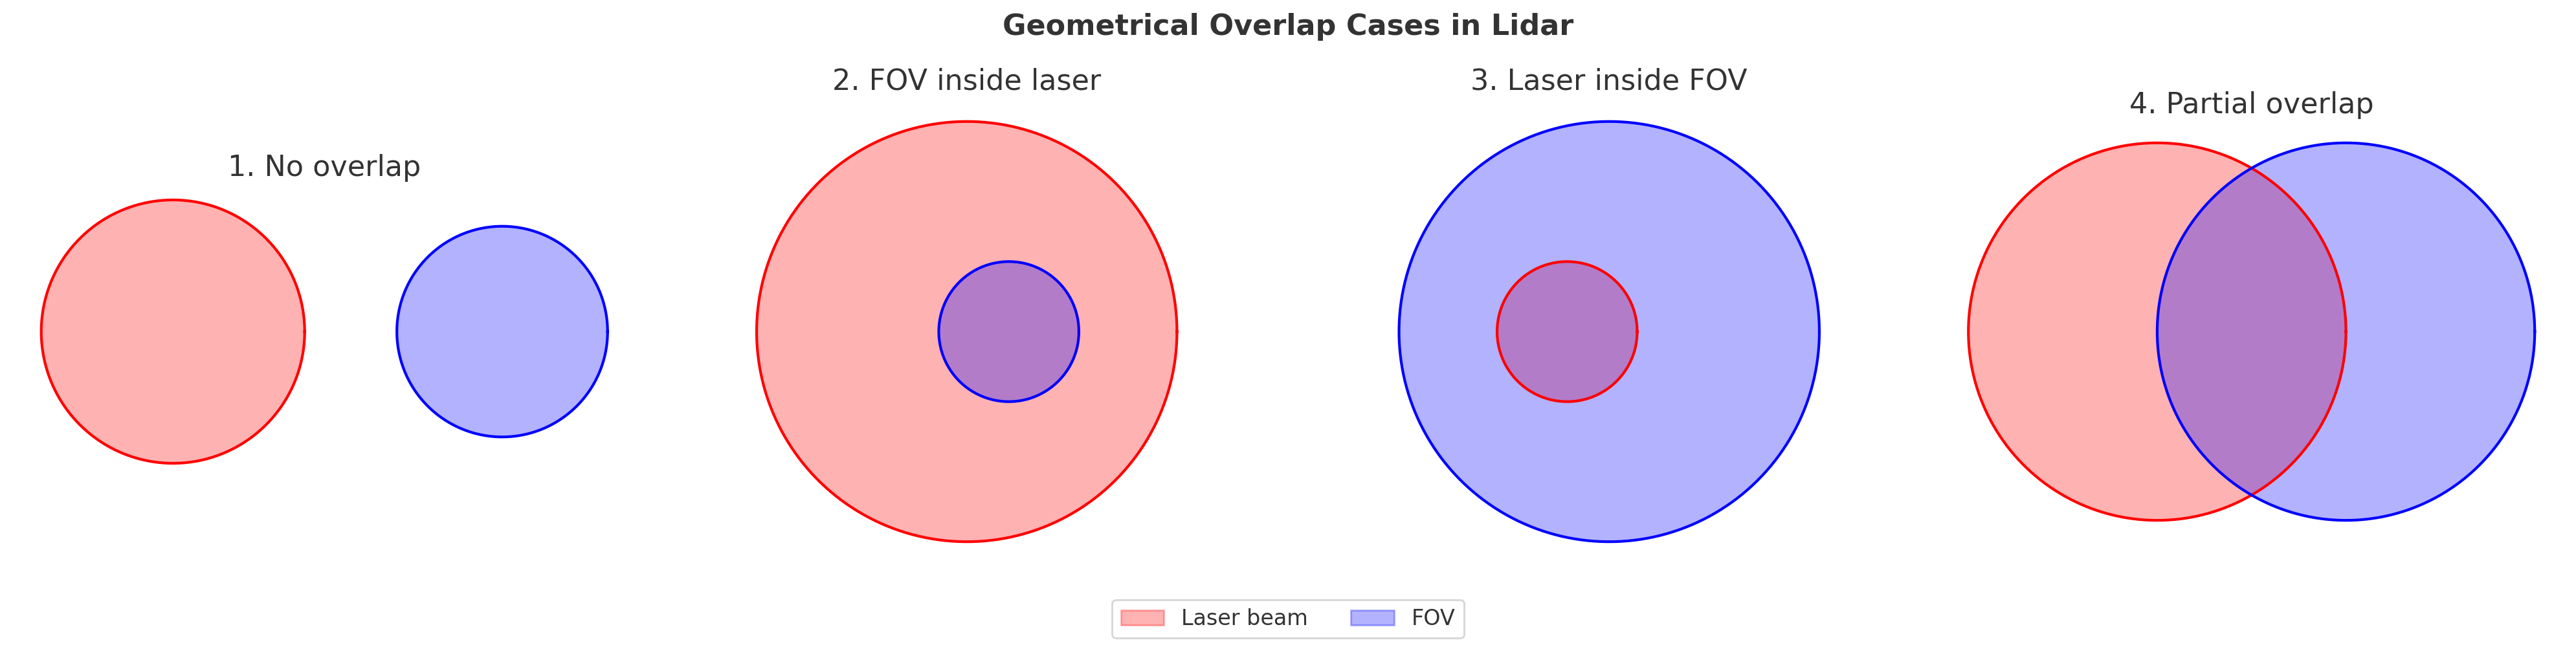

The corresponding intersection area is given by

$A_{\text{intersect}}$ =
\begin{cases}
0, & d_{eff} \geq r_1 + r_2 \quad \text{(no overlap)} \\[8pt]
\pi r_2^2, & d_{eff} \leq |r_1 - r_2|, \; r_2 \text{ inside } r_1 \\[8pt]
\pi r_1^2, & d_{eff} \leq |r_2 - r_1|, \; r_1 \text{ inside } r_2 \\[12pt]
r_1^2 \arccos\!\left(\frac{d_{eff}^2 + r_1^2 - r_2^2}{2 d_{eff} r_1}\right)
+ r_2^2 \arccos\!\left(\frac{d_{eff}^2 + r_2^2 - r_1^2}{2 d_{eff} r_2}\right)
- \tfrac{1}{2} \sqrt{(-d_{eff} + r_1 + r_2)(d_{eff} + r_1 - r_2)(d_{eff} - r_1 + r_2)(d_{eff} + r_1 + r_2)},
& \text{otherwise (partial overlap).}
\end{cases}

where

*   $r_2(z)$ is the receiver FOV radius at range $z$, given by $r_2(z) = z\,\theta_{\mathrm{rec}}$, where $\theta_{\mathrm{rec}}$ is the half-angle receiver FOV.
*   $d_{\mathrm{eff}}$ is the effective lateral separation between the laser and receiver axes, defined as $d_{\mathrm{eff}} = \left| d_0 - z \tan(\theta_{\mathrm{tilt}}) \right|$, where $d_0$ is the separation between the laser and receiver optics at the origin and $\theta_{\mathrm{tilt}}$ is the relative tilt angle.

Schematic diagram of the overlap geometry between the laser beam and the receiver FOV, shown below.

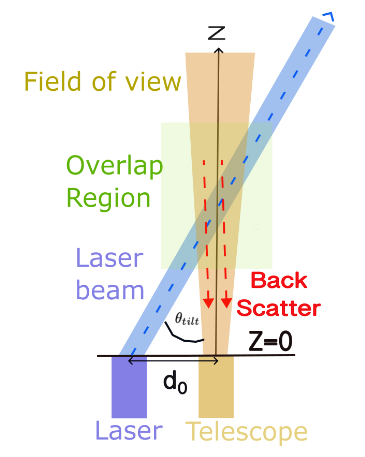

### Fuction

In [ ]:
# --------------------------
# Geometrical overlap function (including tilt)
# --------------------------
def calculate_overlap_factor(z, d0, w0, theta_t, theta_rec, theta_tilt):
  """
  Calculates the geometrical LiDAR overlap factor γ(z) ∈ [0, 1].
  This function models the fraction of the laser beam cross-section that overlaps with the receiver field of view (FOV) for a biaxial
  LiDAR geometry, including the effect of relative tilt.

  Inputs:
    z          - m, range at which to evaluate the overlap
    d0         - m, initial separation distance between laser and telescope axes (at z=0)
    w0         - m, laser beam radius at aperture (at z=0)
    theta_t    - rad, half-angle beam divergence
    theta_rec  - rad, half-angle receiver FOV
    theta_tilt - rad, tilt angle between laser and telescope axes

  Outputs:
    overlap_factor - array of overlap values between 0 (no overlap) and 1 (full overlap)
  """

  # --- Beam and receiver radii ---
  # Laser beam radius: w(z) ≈ w0 + z * theta_t (small-angle approximation)
  r_laser = w0 + z * theta_t

  # Receiver FOV radius: r_rec(z) ≈ z * theta_rec (small-angle approximation)
  r_fov = z * theta_rec

  # --- Effective lateral separation due to tilt ---
  # Separation between laser and receiver axes as a function of range
  d_eff = np.abs(d0 - z * np.tan(theta_tilt))

  # --- Laser cross-sectional area ---
  A_laser = np.pi * r_laser**2
  A_laser[A_laser == 0] = 1e-9  # Avoid division by zero

  # --- Geometric parameters for circle–circle intersection ---
  r1, r2 = r_laser, r_fov
  d_sq, r1_sq, r2_sq = d_eff**2, r1**2, r2**2

  # --- Safe arguments for arccos terms ---
  arg1_denom = 2 * d_eff * r1
  arg2_denom = 2 * d_eff * r2

  arg1 = np.ones_like(arg1_denom)
  arg2 = np.ones_like(arg2_denom)

  mask1 = arg1_denom > 0
  mask2 = arg2_denom > 0
  mask1[d_eff == 0] = False
  mask2[d_eff == 0] = False

  arg1[mask1] = np.clip((d_sq[mask1] + r1_sq[mask1] - r2_sq[mask1]) / arg1_denom[mask1], -1, 1)
  arg2[mask2] = np.clip((d_sq[mask2] + r2_sq[mask2] - r1_sq[mask2]) / arg2_denom[mask2], -1, 1)

  # --- Square-root term for partial overlap ----
  sqrt_term_val = (-d_eff + r1 + r2) * (d_eff + r1 - r2) * (d_eff - r1 + r2) * (d_eff + r1 + r2)
  sqrt_term = np.sqrt(np.maximum(0, sqrt_term_val))

  # --- Partial overlap area ---
  A_partial = r1_sq * np.arccos(arg1) + r2_sq * np.arccos(arg2) - 0.5 * sqrt_term

  # --- Piecewise definition of intersection area ---
  A_intersect = np.where(
      d_eff >= r1 + r2,          # No overlap
      0.0,
      np.where(
          d_eff <= r1 - r2,      # Receiver FOV fully inside laser beam
          np.pi * r2_sq,
          np.where(
              d_eff <= r2 - r1,  # Laser beam fully inside receiver FOV
              np.pi * r1_sq,
              A_partial          # Partial overlap
          )
      )
  )

  # --- Normalized geometrical overlap factor ---
  overlap_factor = A_intersect / A_laser

  return overlap_factor

# Section 4 Noise Sources
---

**Noise Sources**

In a given Raman channel, apart from Raman scattering from the molecule of interest, other mechanisms can give rise to the system recording a count in a Raman channel. These other mechanisms are considered noise and tend to increase the limit of detectionn (LOD) of the system. These other mechanisms include:

*   detector dark counts,
*   solar background radiation (indoor experiment, set as 0),
*   crosstalk arising from Rayleigh scattering,
*   crosstalk from adjacent Raman channels ($H_2O$).

## Dark Counts

Dark counts are an intrinsic parameter of the single-photon counting detector.

The Poisson distribution gives the probability, $P(k)$, of detecting $k$ photons when the LiDAR equation predicts an average of $P_B$ photons:

$$P(k) = \frac{P_B^k e^{-P_B}}{k!}.$$

For $k = 0$, corresponding to the probability of detecting no photon, this reduces to $P_0 = e^{-P_B}$. For single-photon detectors, the probability of registering a count, $P_C$, is therefore given by $P_C = 1 - P_0$.

### Fuction

In [ ]:
# --------------------------
# Dark count probability function
# --------------------------
def Darkcount(darkcountrate, delta_t):
  """
  Computes the probability of detecting at least one dark count within a given time interval, assuming Poisson statistics.

  Inputs:
    darkcountrate  - counts/s, detector dark count rate
    delta_t        - s, response time of time tagger

  Output:
    prob_count     - [0–1], probability of detecting at least one dark count in the time interval
  """

  # Expected number of dark counts in the response time
  darkcount = darkcountrate * delta_t

  # Probability of observing zero dark counts
  prob_zero = poisson.pmf(0, darkcount)

  # Probability of observing at least one dark count
  return 1 - prob_zero

## Crosstalk from  Rayleigh Scattering

The LiDAR equation can also be applied to model Rayleigh scattering. Reference values for Rayleigh backscattering coefficients of common atmospheric gases (e.g. $H_2$, $N_2$ and $O_2$) can be found in:
> Raymond M. Measures, 1992. Laser remote sensing: fundamentals and applications. J. Wiley. — (p. 43, Table 2.3)

For $H_2$, the Rayleigh scattering differential cross-section at 694.3 nm is $(d\sigma^R/d\Omega) = 0.44 \times 10^{-28} cm^2sr^{-1} @ 694.3nm$.

At the Raman pump wavelength of 355 nm, the Rayleigh scattering cross-sections are:

*   $H_2$ Rayleigh scattering cross-section $(d\sigma^R/d\Omega) = 6.44 \times 10^{-28} cm^2sr^{-1} @355nm$
*   $N_2$ Rayleigh scattering cross-section $(d\sigma^R/d\Omega) = 31.31 \times 10^{-28} cm^2sr^{-1} @355nm$ — 0.78 of total atmosphere
*   $O_2$ Rayleigh scattering cross-section $(d\sigma^R/d\Omega) = 26.34 \times 10^{-28} cm^2sr^{-1} @355nm$ — 0.20 of total atmosphere

The key difference between Raman and Rayleigh LiDAR is that Raman backscattering produces a wavelength-shifted (Stokes) return signal, whereas Rayleigh backscattering occurs at the same wavelength as the pump laser. In addition, Raman scattering cross-sections are typically two orders (∼100 times) of magnitude smaller than Rayleigh scattering cross-sections.

As a result, crosstalk from the Rayleigh channel into the Raman detection channel can represent a significant noise source and must be included in the TCSPC model. In this work, Rayleigh scattering is modelled using a dedicated Rayleigh LiDAR function.

Rayleigh scattering coefficients as a function of wavelength are taken from:

> Bates, D.R., 1984. Rayleigh scattering by air. Planetary and Space Science, 32(6), pp.785-790. https://doi.org/10.1016/0032-0633(84)90102-8

The wavelength-dependent coefficients are interpolated to the Raman pump wavelength used in the simulations.

### Spectrum Data

In [ ]:
# --------------------------
# Rayleigh backscatter spectrum
# --------------------------
# URL to Rayleigh backscatter spectrum (CSV file)
URL_Rayleigh = 'https://www.dropbox.com/scl/fi/rd1nz4c1wnct073aqixgm/Rayleigh-Scattering.csv?rlkey=13h3z6475m8fwznnkjufk8fzz&raw=1'  # Remember to replace dl = 0 with raw = 1

# Read the atmospheric transmission data into a pandas DataFrame (skip header rows)
Rayleigh = pd.read_csv(URL_Rayleigh, skiprows=3)

# Display the first few rows to check the data format
Rayleigh.head()

,Wavelength [nm],Refractive Index(n-1)E4,Scattering coefficent [cm2],Back ScatterCross Section (cm2/sr),Effective King,Refractive index
0,200,3.421,3.620000e-25,4.310000e-26,1.080,1.000342
1,205,3.384,3.200000e-25,3.810000e-26,1.077,1.000338
2,210,3.352,2.840000e-25,3.380000e-26,1.074,1.000335
3,215,3.323,2.540000e-25,3.020000e-26,1.072,1.000332
4,220,3.298,2.270000e-25,2.700000e-26,1.070,1.000330


### Fuctions

In [ ]:
# --------------------------
# Air Rayleigh backscatter function
# --------------------------
def Rayleigh_air(Wavelength_nm):
  """
  Interpolate the air Rayleigh backscatter cross-section (cm^2/sr) at a given wavelength.

  CSV (Rayleigh) should have:
    [0]: Wavelength [nm]
    [1]: Back Scatter Cross-Section [cm² sr⁻¹]

  Input:
    Wavelength_nm - nm, wavelength of interest

  Output:
    bs            - cm² sr⁻¹, Rayleigh scattering cross-section
  """

  # Extract wavelength and backscatter data from the Rayleigh table
  w = Rayleigh['Wavelength [nm]'].values
  bs = Rayleigh['Back ScatterCross Section (cm2/sr)'].values

  # Clamp wavelength if outside the data range
  if Wavelength_nm <= w.min():
      print('Wavelength out of range (low); clamped.')
      return bs[0]
  if Wavelength_nm >= w.max():
      print('Wavelength out of range (high); clamped.')
      return bs[-1]

  # Linear interpolation between nearest points
  idx = np.searchsorted(w, Wavelength_nm) - 1
  idx = np.clip(idx, 0, len(w)-2)
  t = (Wavelength_nm - w[idx])/(w[idx+1] - w[idx])

  return bs[idx]*(1 - t) + bs[idx+1]*t


# --------------------------
# Rayleigh LiDAR function (excluding UV transmission and geometrical overlap)
# --------------------------
def Rayleigh_Lidar(Pump_Lambda_nm, Pulse_FWHM_s, Pump_photons,
                   Rayleighxsection_cm2_sr, Distance_m,
                   Lidarconstant, Gas_percent, Receiver_diameter_cm):
  """
  Compute the mean number of Rayleigh photons returned per time bin (per pulse).
  Photon-counting form of the Rayleigh LiDAR equation.

  Inputs:
    Pump_Lambda_nm          - nm, pump wavelength
    Pulse_FWHM_s            - s, laser pulse width (FWHM)
    Pump_photons            - photons per pump pulse
    Rayleighxsection_cm2_sr - cm² sr⁻¹, Rayleigh scattering cross-section at pump wavelngth
    Distance_m              - m, range to scatterers
    Lidarconstant           - (0–1), LiDAR constant (detector and collection optics efficiencies)
    Gas_percent             - %, target gas concentration
    Receiver_diameter_cm    - cm, receiver diamter

  Output:
    Rayleigh_photons        - mean Rayleigh photons per bin (excluding atmospheric transmission and geometrical overlap)
  """

  # Distance and pulse length
  Distance_cm = max(Distance_m*100, 1e-9)  # cm, convert distance to cm (avoid division by zero)
  Pulse_length_cm = Pulse_FWHM_s*c*100     # cm, spatial length of laser pulse

  # Number density of scatterers (cm⁻³) scaled by concentration (%) (Loschmidt constant, see https://en.wikipedia.org/wiki/Loschmidt_constant)
  NumberDensity_cm3 = 2.686e19 * Gas_percent/100  # cm⁻³, number density

  # Receiver collecting area (cm²)
  Receiver_area_cm2 = Pi*(Receiver_diameter_cm/2)**2  # cm²

  # Rayleigh LiDAR equation (photon form)
  Rayleigh_photons = (
      Pump_photons * Lidarconstant * Pulse_length_cm * Receiver_area_cm2 *
      Rayleighxsection_cm2_sr * NumberDensity_cm3 / (Distance_cm**2)
  )

  return Rayleigh_photons


# --------------------------
# Rayleigh photon detection probability (crosstalk into Raman channel)
# --------------------------
def Air_Rayleigh_prob(Pump_Lambda_nm, Crosstalk_Rayleigh, Pulse_FWHM_s,
                      Pump_photons, Distance_m,
                      Lidarconstant, Receiver_diameter_cm):
  """
  Computes the probability of detecting at least one Rayleigh photon leaking into the Raman channel.
  Crosstalk sets the fraction of Rayleigh photons that pass into the Raman detection channel.

  Inputs:
    Pump_Lambda_nm       - nm, pump wavelength
    Crosstalk_Rayleigh   - dimensionless, Rayleigh-to-Raman crosstalk (rejection) factor
    Pulse_FWHM_s         - s, laser pulse width (FWHM)
    Pump_photons         - photons per pump puls
    Distance_m           - m, range to scatterers
    Lidarconstant        - (0–1), overall system efficiency (optics, detector QE, etc.)
    Receiver_diameter_cm - cm, receiver diamter

  Output:
    prob_count           - probability of detecting at least one Rayleigh photon leaking into the Raman detection channel
  """

  # Rayleigh backscatter cross-section for air at the pump wavelength
  Rayleighxsection_Air_cm2_sr = Rayleigh_air(Pump_Lambda_nm)  # cm² sr⁻¹

  # Mean Rayleigh photon count (scaled by crosstalk)
  Gas_Air = 100  # %, treat air as 100% for number density scaling
  Air_count_average = Crosstalk_Rayleigh * Rayleigh_Lidar(Pump_Lambda_nm, Pulse_FWHM_s, Pump_photons,
                                                 Rayleighxsection_Air_cm2_sr, Distance_m,
                                                 Lidarconstant, Gas_Air, Receiver_diameter_cm)

  # Poisson probability of at least one detected photon
  prob_zero = poisson.pmf(0, Air_count_average)

  return 1 - prob_zero

# Section 5 $H_2$ Plume Model
---
**3D Anisotropic Gaussian Diffusion Plume (Steady-State)**

($x-y-z$, $y$ is height)

The hydrogen concentration, expressed as a fraction of the atmosphere and denoted by $H(x,y,z)$, is modelled as a steady-state anisotropic diffusion plume that rises vertically along the $y$ axis while spreading laterally in the $x$ and $z$ directions:

$$H(x,y,z) = \frac{H_{\mathrm{rate}}}{\pi V_{\mathrm{plume}}\,\sigma(y)^2}
\exp\!\left(-\frac{x^2+z^2}{\sigma(y)^2}\right),$$

where the plume width parameter is given by $$\sigma(y) = \sqrt{R_{\mathrm{nozzle}}^{2} + \frac{B D y}{V_{\mathrm{plume}}}}.$$

Here,

*   $H_{\mathrm{rate}}$ is the hydrogen release rate, expressed as a fraction of the atmosphere per second, given by $H_{\mathrm{rate}} = \frac{\rho_{H_2}}{\rho_{\mathrm{air}}}\, Q$.
*   $R_{\mathrm{nozzle}}$ is the radius of the nozzle outlet.
\item $B$ is a buoyancy factor that scales the diffusion coefficient to account for the buoyant nature of hydrogen; for the present experimental set-up, $B \approx 4$.
*   $D$ is the diffusion coefficient of hydrogen in air, taken as $7.8 \times 10^{-5} \text{ m}^2/\text{s}$.
*   $V_{\mathrm{plume}}$ is the characteristic plume rise velocity, given by $V_{\mathrm{plume}} = Q / (\pi R_{\mathrm{nozzle}}^{2})$.

The model predicts $H(x,y,z)$ as a dimensionless volume fraction. Conversion to parts per million (ppm) is given by

$$\mathrm{ppm} = H(x,y,z)\times 10^{6}.$$

---
The transverse plume width $\sigma(y)$ is governed by molecular diffusion acting over the residence time of the plume. Assuming a constant upward advection velocity, the residence time at height $y$ is given by

$$t(y) = \frac{y}{V_{\mathrm{plume}}}.$$

For two-dimensional transverse diffusion in the $(x,z)$ plane, the mean-square displacement is

$$\langle x^2 + z^2 \rangle = 4 D t,$$

where $D$ is the diffusion coefficient of hydrogen in air.

Including the initial nozzle radius $R_{\mathrm{nozzle}}$, the plume width is therefore expressed as

$$\sigma(y) = \sqrt{R_{\mathrm{nozzle}}^2 + \frac{4 D y}{V_{\mathrm{plume}}}}.$$

In [ ]:
# --------------------------
# Steady-state anisotropic Gaussian diffusion plume
# --------------------------
def Steady_Diffusion_plume(phi, x, y, z, x_0, y_0, z_0):
  """
  Steady-state diffusion-based Gaussian plume from a continuous point source.

  Input:
    phi           - mol/s, leak rate
    x, y, z       - m, spatial coordinates
    x_0, y_0, z_0 - m, source coordinates

  Returns:
    H_xyz         - dimensionless, hydrogen volume fraction at (x,y,z)
  """
  # Diffusion coefficient for H2 in air (m^2/s)
  D = D_h2_in_air = 7.78e-5      # m²/s, https://www.engineeringtoolbox.com/air-diffusion-coefficient-gas-mixture-temperature-d_2010.html

  # Gas and nozzle parameters
  rho_H2 = 0.0824            # kg/m³, H2 density (25°C, 1 atm)
  rho_air = 1.184            # kg/m³, air density (25°C, 1 atm)
  D_nozzle = 0.005           # m, nozzle diameter (5 mm)
  R_nozzle = D_nozzle / 2    # m, nozzle radius
  C_H2 = 40.9                # mol/m³, H2 molar density (25°C, 1 atm)

  # Convert leak rate (mol/s) to volumetric flow rate (m^3/s)
  Q_m3_s = phi / C_H2  # m³/s

  # Convert to an air-equivalent injection rate (dimensionless * m^3/s)
  H_rate = (rho_H2 / rho_air) * Q_m3_s

  # Exit velocity at the nozzle (m/s)
  V_plume = Q_m3_s / (np.pi * R_nozzle**2)  # m/s

  # Vertical distance from the source (assumes upward advection at speed V_plume)
  Y = np.maximum((y - y_0), 1e-9)  # avoid zero or negative distances

  # Plume spread parameter (m)
  sigma_y = np.sqrt(R_nozzle**2 + (4 * D * Y) / V_plume)

  # Radial distance term in the cross-section plane
  radial_term = (x - x_0)**2 + (z - z_0)**2

  # Gaussian concentration profile (dimensionless fraction)
  H_xyz = (H_rate / (np.pi * V_plume * sigma_y**2)) * \
        np.exp(-radial_term / sigma_y**2)

  return H_xyz


# --------------------------
# Convert fraction to percent
# --------------------------
def H_fraction_to_percent(H_xyz):
    return H_xyz * 100.0

# Section 6 Input Parameters
---
## Laser
*   `Pump_Lambda` – pump wavelength [nm]
*   `Pulse_FWHM_ns` – pulse width [ns]
*   `Pulse_energy_uJ` – pulse energy [μJ]
*   `rep_rate` – repetition rate [Hz or s⁻¹]

---
## LiDAR & Collection Optics
*   `Lidarconstant_H2` – (0–1), $H_2$ LiDAR constant (detector and collection optics efficiencies)
*   `Lidarconstant_N2` – (0–1), $N_2$ LiDAR constant (detector and collection optics efficiencies)
*   `Receiver_diameter_cm` – receiver diamter [cm]
*   `Crosstalk_Rayleig` – crosstalk: Rayleigh to Raman leakage fraction
*   `Crosstalk_H2O`– crosstalk: $H2_O$ Raman to $H_2$ Raman leakage fraction
*   `darkcountrate` – detector dark count rate [counts/s or s⁻¹]

---
## Signal processing & timming
*   `delta_t` – time-tagger resolution [s]
*   `dead_time_ns` – detector dead time [ns]
*   `integration_time` – integration time [s]
*   `Start_m` – starting distance [m]
*   `distance_range_m` – maximum measurement range [m]

---
## Overlap function (biaxial LiDAR geometry)
*   `d0_overlap` – laser–telescope initial separation [m]
*   `w0_beam` – beam radius at aperture [m]
*   `theta_t` – half-angle divergence [rad]
*   `theta_rec` – receiver half-angle FOV [rad]
*   `theta_tilt` – tilt angle between laser and telescope axes [rad]

---
## Raman scattering
1.   $H_2$
*   `H2_Ramanxsection` – $H_2$ Stokes shift [cm⁻¹]
*   `H2_RamanStokes` – $H_2$ Stokes shift [cm⁻¹]

2.   $N_2$
*   `N2_Ramanxsection` – $N_2$ Stokes shift [cm⁻¹]
*   `N2_RamanStokes` – $N_2$ Stokes shift [cm⁻¹]

2.   $H_2O$
*   `H2O_Ramanxsection` – $H_2O$ Stokes shift [cm⁻¹]
*   `H2O_RamanStokes` – $H_2O$ Stokes shift [cm⁻¹]



In [ ]:
# --------------------------
# Inputs Parameters
# --------------------------
# Laser
Pump_Lambda = 355                        # nm, pump wavelngth
Pulse_FWHM_ns  = 0.82                    # ns, laser pulse width (FWHM) used in LiDAR equation
Pulse_energy_uJ = 3.527                  # μJ, pulse energy
rep_rate = 10000                         # Hz or s⁻¹, laser repetition rate

Pulse_FWHM_s   = Pulse_FWHM_ns * 1e-9    # s, convert pulse width to seconds
Pulse_sigma_s  = Pulse_FWHM_s / 2.355    # s, Gaussian-equivalent pulse width for timing jitter: σ = FWHM / (2√(2 ln 2)) ≈ FWHM / 2.355
Pump_Wavenumber = 1/(Pump_Lambda*1e-7)   # cm⁻¹, pump wavenumber
Pump_photons = (Pulse_energy_uJ*1e-6) / (h*c/(Pump_Lambda*1e-9))  # number of photons per pump pulse

# LiDAR & collection optics
Lidarconstant_H2 = 0.0185                # (0–1), H2 LiDAR constant (detector and collection optics efficiencies)
Lidarconstant_N2 = 0.0044                # (0–1), N2 LiDAR constant (detector and collection optics efficiencies)
Receiver_diameter_cm = 15.2              # cm, receiver diamter
Crosstalk_Rayleigh = 1.0e-12             # crosstalk: Rayleigh to Raman leakage fraction
Crosstalk_H2O = 1.0e-6                   # crosstalk: H2O Raman to H2 Raman leakage fraction
darkcountrate = 12000                    # counts/s or s⁻¹, detector dark count rate

# Signal processing & timming
delta_t = 50e-12                         # s, time-tagger resolution (50 ps bins)
dead_time_ns = 20                        # ns, detector dead time
integration_time = 600                   # s, integration time (10 mins)
Start_m = 0                              # m, starting distance
distance_range_m = 12                    # m, maximum measurement range

number_of_pulses = int(integration_time*rep_rate)  # total number of laser pulses
time_range_s = 2*distance_range_m/c                # s, time window corresponding to round-trip range
number_of_timesteps = int(time_range_s/delta_t)    # number of time steps (can be mapped to distance steps)
time_array = np.linspace(0, number_of_timesteps, number_of_timesteps, endpoint=False) * delta_t  # s, time arrays (can be mapped to distance arrays)
distance_z = time_array * c / 2                    # m, time-of-flight (mapping time to distance)
pulse_in_timesteps = max(1, int(round(Pulse_sigma_s/delta_t)))    # pulse width (Gaussian σ) expressed in timesteps
deadtime_steps = max(1, int(round((dead_time_ns*1e-9)/delta_t)))  # detector dead time expressed in timesteps

# Overlap function parameters (biaxial LiDAR geometry)
d0_overlap = 0.534            # m, laser–telescope initial separation (534 mm)
w0_beam = 1.0e-4              # m, beam radius at aperture (0.10 mm)
theta_t = 5.0e-4              # rad, half-angle divergence (0.5 mrad)
theta_rec = 8.5e-4            # rad, receiver half-angle FOV (0.85 mrad)
theta_tilt = np.deg2rad(2.8)  # rad, tilt angle between laser and telescope axes (~2.8°, 48.9 mrad tilt)

# Compute overlap vs distance (assumes calculate_overlap_factor is defined elsewhere)
overlap_arr = calculate_overlap_factor(distance_z, d0_overlap, w0_beam, theta_t, theta_rec, theta_tilt)


# --------------------------
# H2 gas cloud (steady-state Gaussian plume - anisotropic)
# --------------------------
leak_rate_mL_min = 24.839   # mL/min, hydrogen leak rate
Heightabove_leak = 0.0155   # m, vertical distance above the nozzle (15.5 mm)

x_0 = 0                     # m, x-position of leak (laser aligned with plume centre)
y_0 = 0                     # m, y-position of leak
z_0 = 10.965                # m, distance from LiDAR receiver to leak source

x = 0                       # m, laser passes through plume centre
y = Heightabove_leak        # m, laser height above leak source

Background_H2_ppm = 0.53    # ppm, natural atmospheric H2 background (≈ 530 ppb)

# Convert leak rate to mol/s (Ideal Gas Law: PV = nRT - https://en.wikipedia.org/wiki/Ideal_gas_law, 25 °C, 1 atm)
R_ideal = 0.082057          # L·atm/(mol·K), ideal gas constant - https://en.wikipedia.org/wiki/Gas_constant
T_K = 298.15                # K, temperature (25°C)
P_atm = 1                   # atm, pressure

# n = PV / (RT)
mol_per_min = (P_atm * (leak_rate_mL_min/1000)) / (R_ideal * T_K)  # mol/min, leak rate
phi_mol_s = mol_per_min / 60.0                                     # mol/s, leak rate

# H2 concentration along the LiDAR range
Gas_conc_percent_H2 = np.zeros(number_of_timesteps)
for i in range(number_of_timesteps):
    H_xyz = Steady_Diffusion_plume(phi_mol_s, x, y, distance_z[i], x_0, y_0, z_0)
    Gas_conc_percent_H2[i] = (
        H_fraction_to_percent(H_xyz) + Background_H2_ppm * 1e-4
    )  # %
# Convert to ppm
C_ppm_H2 = Gas_conc_percent_H2 * 1e4  # ppm
peak_H2 = np.max(C_ppm_H2)            # ppm, peak H2 concentration


# --------------------------
# N2 gas concentration (constant background)
# --------------------------
Gas_conc_percent_N2 = np.zeros(number_of_timesteps)
for i in range(number_of_timesteps):
    Gas_conc_percent_N2[i] = 78.0     # %, N2 assumed constant
C_ppm_N2 = Gas_conc_percent_N2 * 1e4  # ppm


# --------------------------
# Raman scattering parameters (H2, N2, H2O)
# --------------------------
# H2
H2_Ramanxsection_355 = 7.07e-30                                  # cm² sr⁻¹, H2 Raman scattering cross-section @ 355 nm
H2_Ramanxsection = H2_Ramanxsection_355*(355/Pump_Lambda)**4     # cm² sr⁻¹, H2 Raman scattering cross-section @ pumpwavelgnth
H2_RamanStokes = 4160.2                                          # cm⁻¹, H2 Stoke's shift (wavenumbers)
H2_Raman_wavelength = 1/(Pump_Wavenumber - H2_RamanStokes)*1e7   # nm, H2 Stoke's shift (wavelength)

# N2
N2_Ramanxsection_355 = 2.28e-30                                  # cm² sr⁻¹, N2 Raman scattering cross-section @ 355 nm
N2_Ramanxsection = N2_Ramanxsection_355*(355/Pump_Lambda)**4     # cm² sr⁻¹, N2 Raman scattering cross-section @ pumpwavelgnth
N2_RamanStokes = 2330.7                                          # cm⁻¹, N2 Stoke's shift (wavenumbers)
N2_Raman_wavelength = 1/(Pump_Wavenumber - N2_RamanStokes)*1e7   # nm, N2 Stoke's shift (wavelength)

# H2O
H2Oconcentration = 1.2                                            # %, atmospheric water vapour
H2O_Ramanxsection_355 = 6.34e-30                                  # cm² sr⁻¹, H2O Raman scattering cross-section @ 355 nm
H2O_Ramanxsection = H2O_Ramanxsection_355*(355/Pump_Lambda)**4    # cm² sr⁻¹, H2O Raman scattering cross-section @ pumpwavelgnth
H2O_RamanStokes = 3651.7                                          # cm⁻¹, H2O Stoke's shift (wavenumbers)
H2O_Raman_wavelength = 1/(Pump_Wavenumber - H2O_RamanStokes)*1e7  # nm, H2O Stoke's shift (wavelength)


# --------------------------
# Printing & Plotting
# --------------------------
# Print some of the Lidar parameters
print('--- Parameters for this run (CryLas) ---')
print(f"Laser pulse width (FWHM): {Pulse_FWHM_ns:.2f} ns")
print(f"pulse standard deviation (σ): {Pulse_sigma_s / 1e-9:.2f} ns")
print(f"H2 Lidar efficiency: {Lidarconstant_H2:.5f}")
print(f"N2 Lidar efficiency: {Lidarconstant_N2:.5f}")
print(f"\nNumber of pump photons: {Pump_photons:.3e}")
print(f"Number of pulses: {number_of_pulses:.1f}")
print(f"Pump wavelngth [nm]: {Pump_Lambda:.1f},", f"H2 Stokes wavelength [nm]: {H2_Raman_wavelength:.1f},", f"N2 Stokes wavelength [nm]: {N2_Raman_wavelength:.1f},", f"H2O Stokes wavelength [nm]: {H2O_Raman_wavelength:.1f}")
print(f'Number of timesteps : {number_of_timesteps:.1f}')

# Natural backgound of H2 in the atmosphere
print('\n--- H2 gas cloud ---')
print(f"Background_H2: {Background_H2_ppm} ppm")
print("--- Inputs ---")
print(f"Leak rate: {leak_rate_mL_min:.3f} mL/min")
print("--- Output ---")
print(f"Calculated leak rate (phi): {phi_mol_s:.4e} mol/s (ideal gas @25°C, 1 atm)")
print(f"H2 max concentration: {peak_H2:.1f} ppm @ {z_0:0.3f} m")

print('\n--- N2 gas cloud ---')
print(f"N2 concentration (mean): {C_ppm_N2.mean():.1f} ppm")

--- Parameters for this run (CryLas) ---
Laser pulse width (FWHM): 0.82 ns
pulse standard deviation (σ): 0.35 ns
H2 Lidar efficiency: 0.01850
N2 Lidar efficiency: 0.00440

Number of pump photons: 6.303e+12
Number of pulses: 6000000.0
Pump wavelngth [nm]: 355.0, H2 Stokes wavelength [nm]: 416.5, N2 Stokes wavelength [nm]: 387.0, H2O Stokes wavelength [nm]: 407.9
Number of timesteps : 1601.0

--- H2 gas cloud ---
Background_H2: 0.53 ppm
--- Inputs ---
Leak rate: 24.839 mL/min
--- Output ---
Calculated leak rate (phi): 1.6921e-05 mol/s (ideal gas @25°C, 1 atm)
H2 max concentration: 1850.0 ppm @ 10.965 m

--- N2 gas cloud ---
N2 concentration (mean): 780000.0 ppm


# Section 7 The TCSPC model
---
The stochastic photon detection process is implemented using a Monte-Carlo TCSPC algorithm that models individual photon arrival events under realistic signal and noise conditions. The TCSPC core of the model employs a dual-loop structure, with an outer loop iterating over laser pulses and an inner loop scanning time steps that are mapped to discrete distance steps along the LiDAR propagation path.

The outer loop corresponds to the pump laser pulse cycle and spans all laser pulses emitted during the integration period $t_i$. One laser pulse is processed per iteration, and the total number of pulses within the integration period is $N_{\mathrm{pulse}} = t_i\, f_r$, where $f_r$ represents the laser repetition frequency. Furthermore, the spatial resolution of the Raman LiDAR system is influenced by the laser pulse width, $P_w$. The associated uncertainty in the range measurement, $\Delta z$, is given by $\Delta z \approx P_w\, c$. Typically, the laser pulse width lies in the range of 0.1-10~ns, indicating that the pump laser pulse width is the dominant contributor to the overall range uncertainty $\Delta z$.

The inner loop operates as a time-ordered step-scanning procedure. The step width is determined by the temporal resolution of the Time Tagger, denoted by $\delta t$. As an illustration, the Swabian Instruments Time Tagger provides a temporal resolution of approximately 50~ps For a total distance window $Z_{\mathrm{total}}$, the corresponding round-trip time window is $T_{\mathrm{window}} = 2 Z_{\mathrm{total}} / c$, where $c$ is the speed of light. The number of discrete time steps is therefore $N_{\mathrm{steps}} = T_{\mathrm{window}} / (\delta t) = 2 Z_{\mathrm{total}} / (c\,\delta t)$. Each time step maps to a corresponding propagation distance increment $\delta z = c\,\delta t / 2$.

At each time step (mapped to a distance increment $\delta z$) in the inner loop, the model uses precomputed per-step detection probabilities representing the probability of detecting one or more photons during a single laser pulse. For Raman backscatter components, the expected mean photon number is estimated using the LiDAR equation in combination with the target gas concentration profile, and is converted to a detection probability using Poisson statistics. For the target gas concentration, two cases are considered. In the $H_2$ Raman channel, the hydrogen plume model is used to estimate the hydrogen number density, $N_{H_2}$, as a function of range $z$. In the $N_2$ Raman channel, the nitrogen number density, $N_{N_2}$, is assumed to be independent of $z$ and with a constant mole fraction of 0.78 in air. Contributions from non-backscattering mechanisms (e.g., dark counts) are included as additional probability terms. The total per-step detection probability ($p_{\mathrm{total}}$) is formed by summing these contributions, and a Bernoulli trial is performed at each step to determine whether a detection occurs. Specifically, a uniformly distributed random number $U$ in the interval $[0,1)$ is generated, and a detection event is recorded if $U$ is less than $p_{\mathrm{total}}$.

When a photon detection occurs, a zero-mean Gaussian random time shift is applied to the detected time step to account for timing jitter introduced by the finite laser pulse width $P_w$, thereby modelling the temporal spread of photon arrival times. If the jittered bin index lies within the valid histogram range, a single count is accumulated in the corresponding step. Detector dead time $t_D$ is then enforced by skipping subsequent discrete steps corresponding to an inactive distance interval $z_{\text{dead}} = c\,t_D/2$, ensuring that no additional detections are registered during this period.

By repeating this Monte-Carlo process over all laser pulse iterations, the algorithm reproduces the stochastic behaviour of photon detection, including Poisson-distributed photon arrivals, temporal jitter, and detector dead time effects. The resulting accumulated TCSPC histogram represents the statistical distribution of photon arrival times, which is mapped to the range $z$ using the time-of-flight relation $z = c\,t/2$.

### Gaussian Timing Jitter

Due to the finite laser pulse width, there is an inherent temporal uncertainty in assigning detected photons to discrete time steps. This uncertainty is modelled by assuming a Gaussian temporal pulse shape and applying a Monte-Carlo approach, in which detected photon arrival times are randomly sampled from a Gaussian distribution.

The standard deviation of the Gaussian pulse, $\sigma$, of this distribution is related to the laser pulse full width at half maximum (FWHM), $P_w(\text{FWHM})$ by

$$\sigma = \frac{P_w(\text{FWHM})}{2\sqrt{2\ln 2}} \approx \frac{P_w(\text{FWHM})}{2.355},$$

where $P_w(\text{FWHM}$ is laser pulse width (FWHM) used in the LiDAR equation. The corresponding uncertainty in the allocation of photon counts to discrete time steps is expressed as $Δn=\sigma/t_b$, where $t_b$ denotes the width of a single time step. This procedure accounts for temporal jitter arising from the finite laser pulse duration and accurately reproduces the spread in photon arrival times observed in TCSPC measurements.

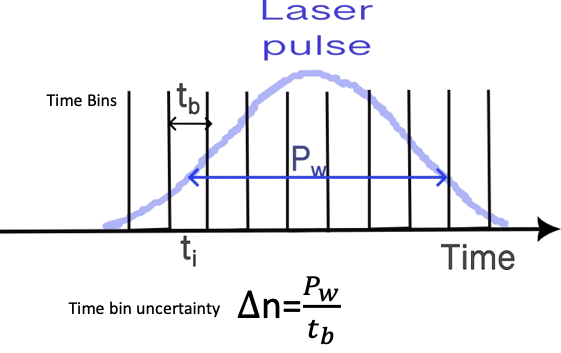

### Dead Time

For single-photon detectors, the detection of a photon is followed by a dead time during which the detector is temporarily insensitive and unable to register additional photon arrivals.

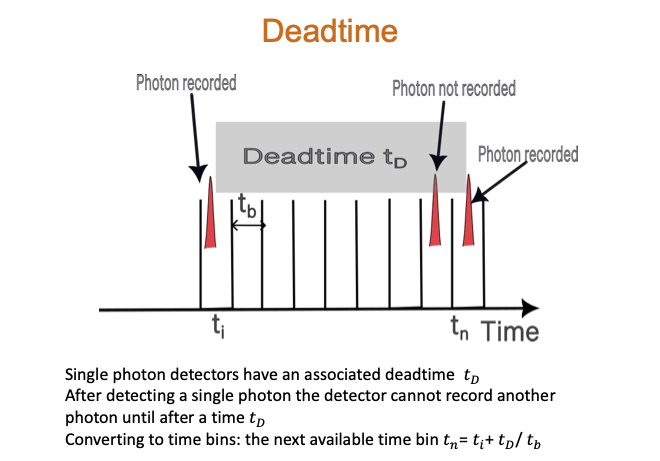

## Modelled $H_2$ Raman
C(H2) = 1850 ppm @ 10.965 m, indoor: prob_{sky} = 0

integration_time = 600s: 355nm, 0.82ns, 3.527uJ, 10kHz (CryLas)

Lidar efficiency: 0.0185

Number of pulses: 6,000,000

In [ ]:
# ==========================================================
# Monte-Carlo TCSPC Raman LiDAR Simulation
# ==========================================================
# Description:
#   This section implements a Monte-Carlo Time-Correlated Single-Photon Counting (TCSPC) model for Raman LiDAR hydrogen (H2) detection.
#   The algorithm follows a dual-loop structure:
#     1) A per-range-step detection probability is precomputed for each time step (mapped to distance), including contributions from: H2 Raman signal,
#        Rayleigh crosstalk leakage, H2O Raman crosstalk, detector dark counts (and solar background, if present)
#     2) For each laser pulse, the time steps are scanned sequentially from near to far (time-ordered).
#     3) At each step, a Bernoulli trial is performed using the precomputed per-step detection probability.
#     4) When a photon detection occurs, a single event is recorded in the TCSPC histogram after applying Gaussian timing jitter to account for finite laser pulse width.
#     5) Detector dead time is enforced by skipping a fixed number of subsequent steps, suppressing further detections while the detector is inactive.
#     6) Repeating this process over many laser pulses builds an accumulated TCSPC histogram of photon arrival times.
# ==========================================================

# --------------------------
# Exclude steps before Start_m
# --------------------------
# Identify the first time step corresponding to the start distance
i_start = np.searchsorted(distance_z, Start_m)

# Restrict arrays to valid time-ordered (range-mapped) steps
distance_z = distance_z[i_start:]                    # valid distance steps (time-ordered)
overlap_arr = overlap_arr[i_start:]                  # geometrical overlap factor
Gas_conc_percent_H2 = Gas_conc_percent_H2[i_start:]  # H2 concentration profile aligned to steps


# --------------------------
# Precompute per-step detection probabilities (≥1 photon per pulse)
# --------------------------
# Each array below represents the probability that at least one photon is detected in a given time stepn during a single laser pulse.
# These probabilities are evaluated once and reused in the Monte-Carlo loop to improve computational efficiency.

# === H2 Raman signal ===
# Convert mean photon number λ_H2 → detection probability P(≥1) = 1 − exp(−λ_H2)
prob_H2_Raman_arr = 1 - np.exp(-np.array([
    Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                H2_Ramanxsection, H2_RamanStokes, z_here,
                Lidarconstant_H2, Gas_conc_percent_H2[i], Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)          # forward (pump) transmission
    * uv_transmission(H2_Raman_wavelength, z_here)  # backward (Raman return) transmission
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Rayleigh crosstalk leakage ===
# Probability of detecting ≥1 Rayleigh photon leaking into the Raman channel
prob_air_Rayleigh_arr_H2 = np.array([
    Air_Rayleigh_prob(Pump_Lambda, Crosstalk_Rayleigh, Pulse_FWHM_s,
                      Pump_photons, z_here,
                      Lidarconstant_H2, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)**2       # forward + backward transmission
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
])

# === H2O Raman crosstalk ===
# Convert mean photon number λ_H2O → detection probability P(≥1)
prob_H2O_Raman_arr_H2 = 1 - np.exp(-np.array([
    Crosstalk_H2O * Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                                H2O_Ramanxsection, H2O_RamanStokes, z_here,
                                Lidarconstant_H2, H2Oconcentration, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)           # forward (pump) transmission
    * uv_transmission(H2O_Raman_wavelength, z_here)  # backward (Raman return) transmission
    * overlap_arr[i]                                 # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Dark count and solar background ===
prob_dark_H2 = Darkcount(darkcountrate, delta_t)     # constant dark count probability per step
prob_sky_H2 = 0                                      # no sky background included (indoor laboratory experiment)


# === Total per-step detection probability ===
# Sum of all signal and noise contributions (clipped to [0,1])
prob_total_arr_H2 = np.clip(prob_H2_Raman_arr + prob_air_Rayleigh_arr_H2 + prob_H2O_Raman_arr_H2 + prob_dark_H2 + prob_sky_H2, 0, 1)


# --------------------------
# Monte-Carlo TCSPC simulation
# --------------------------
# TCSPC simulation.
# Outer loop over laser pulses, inner loop scans time steps (can be mapped to distance steps).
# First detection after dead time is recorded per pulse
@njit
def run_tcspc(prob_total_arr_H2, number_of_pulses, deadtime_steps, pulse_in_timesteps):
  """
  Monte-Carlo simulation of TCSPC photon detection for Raman LiDAR H2 sensing.
  Each TCSPC time step (mapped to a distance step) has an associated probability of detecting at least one photon during a laser pulse.
  Steps are scanned in time order, and detected photons are subject to Gaussian timing jitter and detector dead time.

  Inputs:
    prob_total_arr_H2  - [0–1], probability of detecting H2 ≥1 photon in each step
    number_of_pulses   - number of laser pulses (Monte-Carlo iterations)
    deadtime_steps     - detector dead time (in time steps); suppresses further detections
    pulse_in_timesteps - standard deviation (width) of Gaussian timing jitter (in time steps)

  Output:
    H2_signal_spread   - TCSPC histogram of photon arrival times accumulated over all laser pulses
  """

  # Total number of time steps (each maps to a distance step)
  nsteps_H2 = len(prob_total_arr_H2)

  # Histogram storing first-photon detections only
  H2_signal_spread = np.zeros(nsteps_H2, dtype=np.int32)

  # Outer loop: iterate over all laser pulses
  for j in range(number_of_pulses):

      i = 0  # start from earliest time step
      # Inner loop: time-ordered scan of steps
      while i < nsteps_H2:

          # Bernoulli trial for photon detection
          if np.random.rand() < prob_total_arr_H2[i]:  # draw U ∈ [0,1); detection occurs if U < p_total_arr[i]: photon detected? Yes / No

              # Apply Gaussian timing jitter (pulse width + TCSPC jitter)
              s = i + int(round(np.random.normal(0.0, pulse_in_timesteps)))

              # Register photon if within valid histogram range
              if 0 <= s < nsteps_H2:
                  H2_signal_spread[s] += 1

              # Enforce detector dead time
              i += deadtime_steps

          else:

              i += 1

  return H2_signal_spread

# Run TCSPC Monte-Carlo simulation
H2_signal_spread = run_tcspc(prob_total_arr_H2, number_of_pulses, deadtime_steps, pulse_in_timesteps)


# --------------------------
# Summary & Printing
# --------------------------
print("--- Probability (sum) ---")
print(f"Total probability of a count: {prob_total_arr_H2.sum():.2e}\n"  # μ: expected detection probability per pulse (single-photon TCSPC)
      f"dark: {prob_dark_H2:.2e}\n"
      f"H2 Raman: {prob_H2_Raman_arr.sum():.2e}\n"
      f"air Rayleigh: {prob_air_Rayleigh_arr_H2.sum():.2e}\n"
      f"H2O Raman: {prob_H2O_Raman_arr_H2.sum():.2e}")
print(f"\nBackground_H2: {Background_H2_ppm} ppm")

# Maximum TCSPC step count (accumulated over all pulses)
peak_H2_model = max(H2_signal_spread)
# Find index of the maximum photon count in the TCSPC histogram
idx_model_max_H2 = np.argmax(H2_signal_spread)
z_model_max_H2 = distance_z[idx_model_max_H2]
print(f"Modelled H2 Raman: max {peak_H2_model:.0f} @ {z_model_max_H2:.3f} m")

--- Probability (sum) ---
Total probability of a count: 1.61e-03
dark: 6.00e-07
H2 Raman: 6.48e-04
air Rayleigh: 1.65e-09
H2O Raman: 4.93e-08

Background_H2: 0.53 ppm
Modelled H2 Raman: max 241 @ 10.965 m


### TCSPC result vs gas cloud

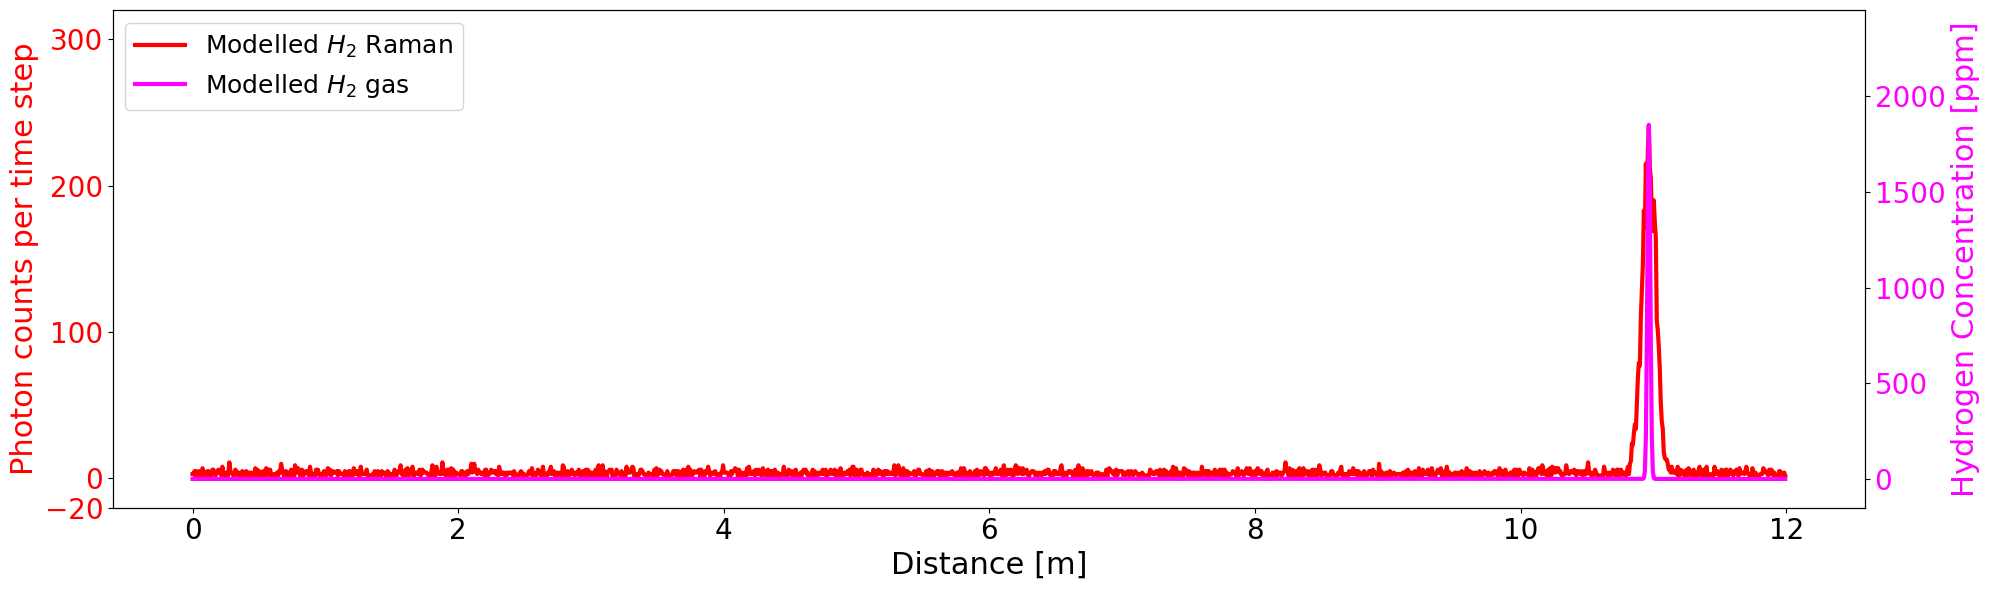

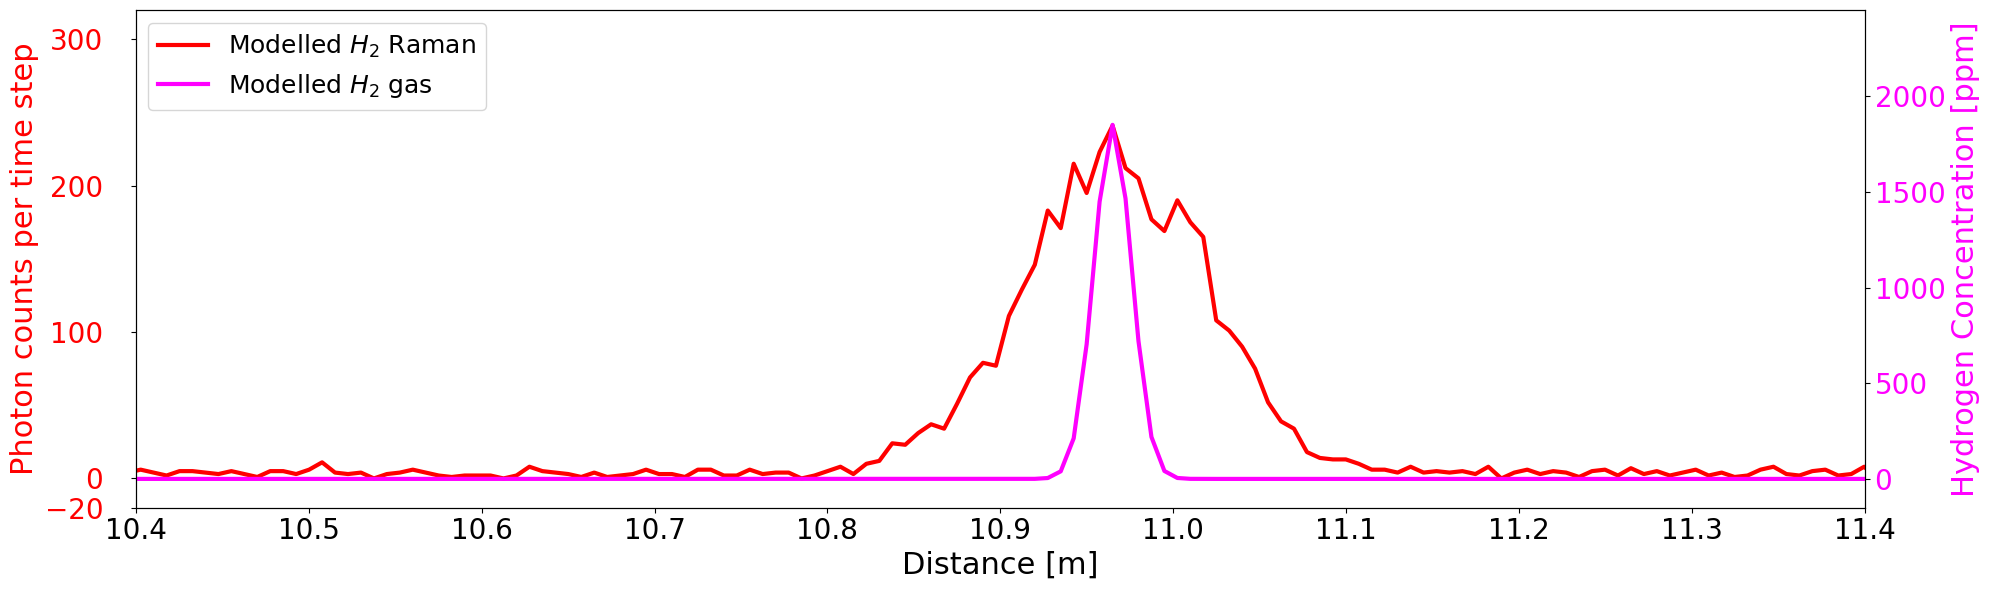

In [ ]:
# --------------------------
# Plot TCSPC result vs gas cloud
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $H_2$ Raman & Gas Concentration - Raman Pump @" + f"{Pump_Lambda:.1f} nm, "
#         + "Stokes @" + f"{H2_Raman_wavelength:.1f} nm", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per time step', color='red', fontsize=22)
ax1.set_ylim(-20, 320)  # set y-axis limits
ax1.set_yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
ax1.plot(distance_z, H2_signal_spread, color='red', linewidth=3, label=f"Modelled $H_2$ Raman")
ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Hydrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.set_ylim(-150, 2450)  # set y-axis limits
ax2.plot(distance_z, Gas_conc_percent_H2*1e4, color='magenta', linewidth=3, label=f"Modelled $H_2$ gas")
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()


# --------------------------
# Plot TCSPC result vs gas cloud (Zoomed in to 10.4–11.4 m)
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $H_2$ Raman and Gas Concentration (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per time step', color='red', fontsize=22)
ax1.set_xlim(10.4, 11.4)  # set x-axis limits
ax1.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax1.set_ylim(-20, 320)  # set y-axis limits
ax1.set_yticks([-20] + list(np.arange(0, 320, 100)))  # set y-tick marks
ax1.plot(distance_z, H2_signal_spread, color='red', linewidth=3, label=f"Modelled $H_2$ Raman")
ax1.tick_params(axis='y', labelcolor='red', labelsize=20, pad=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Hydrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.set_xlim(10.4, 11.4)  # set x-axis limits
ax2.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax2.set_ylim(-150, 2450)  # set y-axis limits
ax2.plot(distance_z, Gas_conc_percent_H2*1e4, color='magenta', linewidth=3, label=f"Modelled $H_2$ gas")
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=18)
plt.tight_layout()
plt.show()

## Modelled $N_2$ Raman
C(N2) = 780,000ppm, indoor: prob_{sky} = 0

integration_time = 600s: 355nm, 0.82ns, 3.527uJ, 10kHz (CryLas)

Lidar efficiency: 0.0044

Number of pulses: 6,000,000

In [ ]:
# ==========================================================
# Monte-Carlo TCSPC Raman LiDAR Simulation
# ==========================================================
# Description:
#   This section implements a Monte-Carlo Time-Correlated Single-Photon Counting (TCSPC) model for Raman LiDAR nitrogen (N2) detection.
#   The algorithm follows a dual-loop structure:
#     1) A per-range-step detection probability is precomputed for each time step (mapped to distance), including contributions from: N2 Raman signal,
#        Rayleigh crosstalk leakage, H2O Raman crosstalk, detector dark counts (and solar background, if present)
#     2) For each laser pulse, the time steps are scanned sequentially from near to far (time-ordered).
#     3) At each step, a Bernoulli trial is performed using the precomputed per-step detection probability.
#     4) When a photon detection occurs, a single event is recorded in the TCSPC histogram after applying Gaussian timing jitter to account for finite laser pulse width.
#     5) Detector dead time is enforced by skipping a fixed number of subsequent steps, suppressing further detections while the detector is inactive.
#     6) Repeating this process over many laser pulses builds an accumulated TCSPC histogram of photon arrival times.
# ==========================================================

# --------------------------
# Exclude steps before Start_m
# --------------------------
# Identify the first time step corresponding to the start distance
i_start = np.searchsorted(distance_z, Start_m)

# Restrict arrays to valid time-ordered (range-mapped) steps
distance_z = distance_z[i_start:]                    # valid distance steps (time-ordered)
overlap_arr = overlap_arr[i_start:]                  # geometrical overlap factor
Gas_conc_percent_N2 = Gas_conc_percent_N2[i_start:]  # N2 concentration profile aligned to steps


# --------------------------
# Precompute per-step detection probabilities (≥1 photon per pulse)
# --------------------------
# Each array below represents the probability that at least one photon is detected in a given time step during a single laser pulse.
# These probabilities are evaluated once and reused in the Monte-Carlo loop to improve computational efficiency.

# === N2 Raman signal ===
# Convert mean photon number λ_N2 → detection probability P(≥1) = 1 − exp(−λ_N2)
prob_N2_Raman_arr = 1 - np.exp(-np.array([
    Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                N2_Ramanxsection, N2_RamanStokes, z_here,
                Lidarconstant_N2, Gas_conc_percent_N2[i], Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)          # forward (pump) transmission
    * uv_transmission(N2_Raman_wavelength, z_here)  # backward (Raman return) transmission
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Rayleigh crosstalk leakage ===
# Probability of detecting ≥1 Rayleigh photon leaking into the Raman channel
prob_air_Rayleigh_arr_N2 = np.array([
    Air_Rayleigh_prob(Pump_Lambda, Crosstalk_Rayleigh, Pulse_FWHM_s,
                      Pump_photons, z_here,
                      Lidarconstant_N2, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)**2       # forward + backward transmission
    * overlap_arr[i]                                # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
])

# === H2O Raman crosstalk ===
# Convert mean photon number λ_H2O → detection probability P(≥1)
prob_H2O_Raman_arr_N2 = 1 - np.exp(-np.array([
    Crosstalk_H2O * Raman_Lidar(Pump_Lambda, Pulse_FWHM_s, Pump_photons,
                                H2O_Ramanxsection, H2O_RamanStokes, z_here,
                                Lidarconstant_N2, H2Oconcentration, Receiver_diameter_cm)
    * uv_transmission(Pump_Lambda, z_here)           # forward (pump) transmission
    * uv_transmission(H2O_Raman_wavelength, z_here)  # backward (Raman return) transmission
    * overlap_arr[i]                                 # geometrical overlap correction
    for i, z_here in enumerate(distance_z)
]))

# === Dark count and solar background ===
prob_dark_N2 = Darkcount(darkcountrate, delta_t)     # constant dark count probability per step
prob_sky_N2 = 0                                      # no sky background included (indoor laboratory experiment)


# === Total per-step detection probability ===
# Sum of all signal and noise contributions (clipped to [0,1])
prob_total_arr_N2 = np.clip(prob_N2_Raman_arr + prob_air_Rayleigh_arr_N2 + prob_H2O_Raman_arr_N2 + prob_dark_N2 + prob_sky_N2, 0, 1)


# --------------------------
# Monte-Carlo TCSPC simulation
# --------------------------
# TCSPC simulation.
# Outer loop over laser pulses, inner loop scans time steps (can be mapped to distance steps).
# First detection after dead time is recorded per pulse
@njit
def run_tcspc(prob_total_arr_N2, number_of_pulses, deadtime_steps, pulse_in_timesteps):
  """
  Monte-Carlo simulation of TCSPC photon detection for Raman LiDAR N2 sensing.
  Each TCSPC time step (mapped to a distance step) has an associated probability of detecting at least one photon during a laser pulse.
  Steps are scanned in time order, and detected photons are subject to Gaussian timing jitter and detector dead time.

  Inputs:
    prob_total_arr_N2  - [0–1], probability of detecting N2 ≥1 photon in each step
    number_of_pulses   - number of laser pulses (Monte-Carlo iterations)
    deadtime_steps     - detector dead time (in time steps); suppresses further detections
    pulse_in_timesteps - standard deviation (width) of Gaussian timing jitter (in time steps)

  Output:
    N2_signal_spread   - TCSPC histogram of photon arrival times accumulated over all laser pulses
  """

  # Total number of time steps (each maps to a distance step)
  nsteps_N2 = len(prob_total_arr_N2)

  # Histogram storing first-photon detections only
  N2_signal_spread = np.zeros(nsteps_N2, dtype=np.int32)

  # Outer loop: iterate over all laser pulses
  for j in range(number_of_pulses):

      i = 0  # start from earliest time step

      # Inner loop: time-ordered scan of steps
      while i < nsteps_N2:

          # Bernoulli trial for photon detection
          if np.random.rand() < prob_total_arr_N2[i]:  # draw U ∈ [0,1); detection occurs if U < p_total_arr[i]: photon detected? Yes / No

              # Apply Gaussian timing jitter (pulse width + TCSPC jitter)
              s = i + int(round(np.random.normal(0.0, pulse_in_timesteps)))

              # Register photon if within valid histogram range
              if 0 <= s < nsteps_N2:
                  N2_signal_spread[s] += 1

              # Enforce detector dead time
              i += deadtime_steps

          else:

              i += 1

  return N2_signal_spread

# Run TCSPC Monte-Carlo simulation
N2_signal_spread = run_tcspc(prob_total_arr_N2, number_of_pulses, deadtime_steps, pulse_in_timesteps)


# --------------------------
# Summary & Printing
# --------------------------
print("\n--- Probability (sum) ---")
print(f"Total probability of a count: {prob_total_arr_N2.sum():.2e}\n"  # μ: expected detection probability per pulse (single-photon TCSPC)
      f"sky: {prob_sky_N2:.0f}\n"
      f"dark: {prob_dark_N2:.2e}\n"
      f"N2 Raman: {prob_N2_Raman_arr.sum():.2e}\n"
      f"air Rayleigh: {prob_air_Rayleigh_arr_N2.sum():.2e}\n"
      f"H2O Raman: {prob_H2O_Raman_arr_N2.sum():.2e}")

# Maximum TCSPC step count (accumulated over all pulses)
peak_N2_model = max(N2_signal_spread)
# Find index of the maximum photon count in the TCSPC histogram
idx_model_max_N2 = np.argmax(N2_signal_spread)
z_model_max_N2 = distance_z[idx_model_max_N2]
print(f"Modelled N2 Raman: max {peak_N2_model:.0f} @ {z_model_max_N2:.3f} m")


--- Probability (sum) ---
Total probability of a count: 2.61e-01
sky: 0
dark: 6.00e-07
N2 Raman: 2.60e-01
air Rayleigh: 3.93e-10
H2O Raman: 1.17e-08
Modelled N2 Raman: max 28544 @ 10.920 m


### TCSPC result vs gas cloud

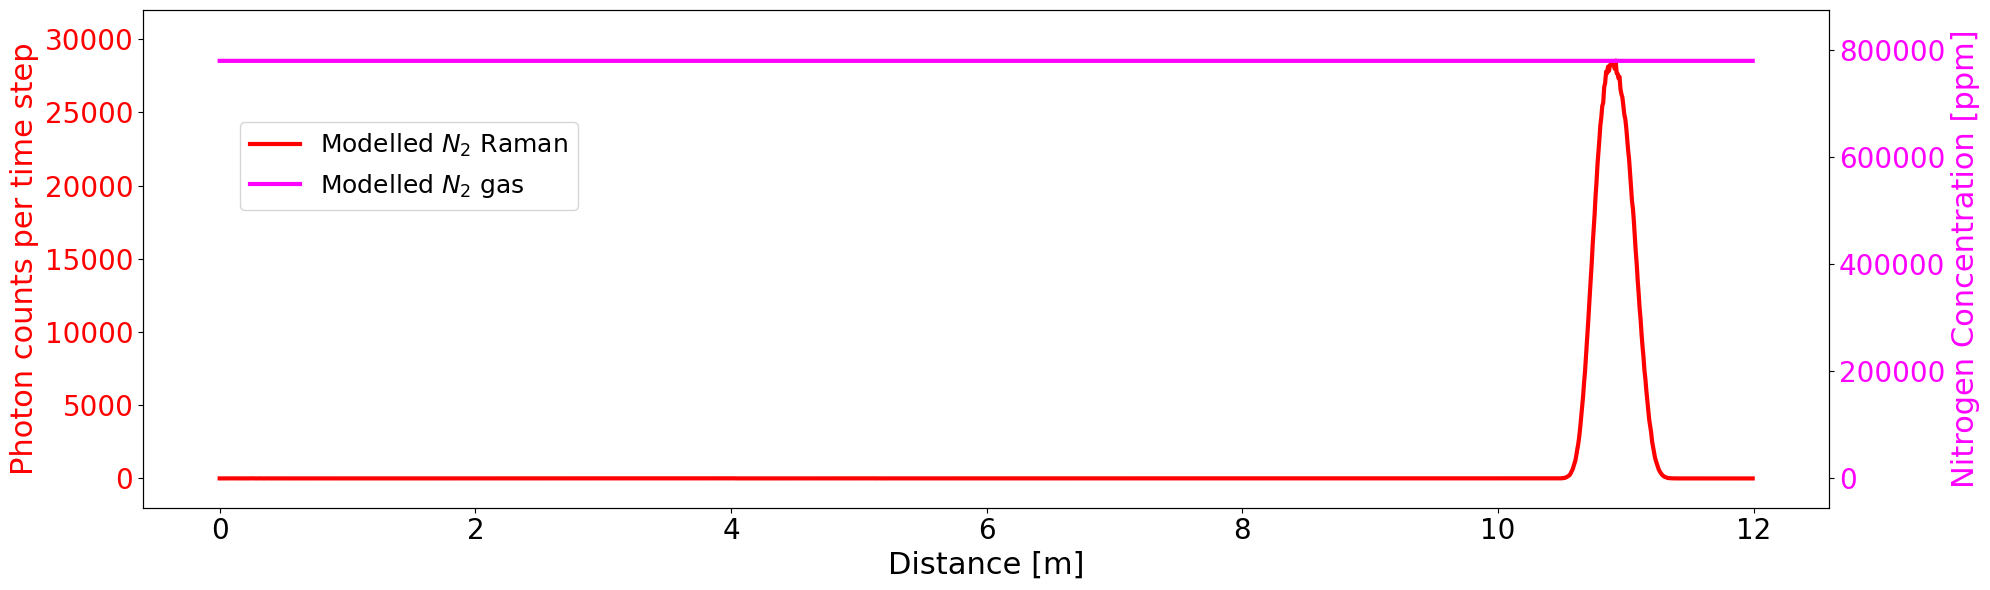

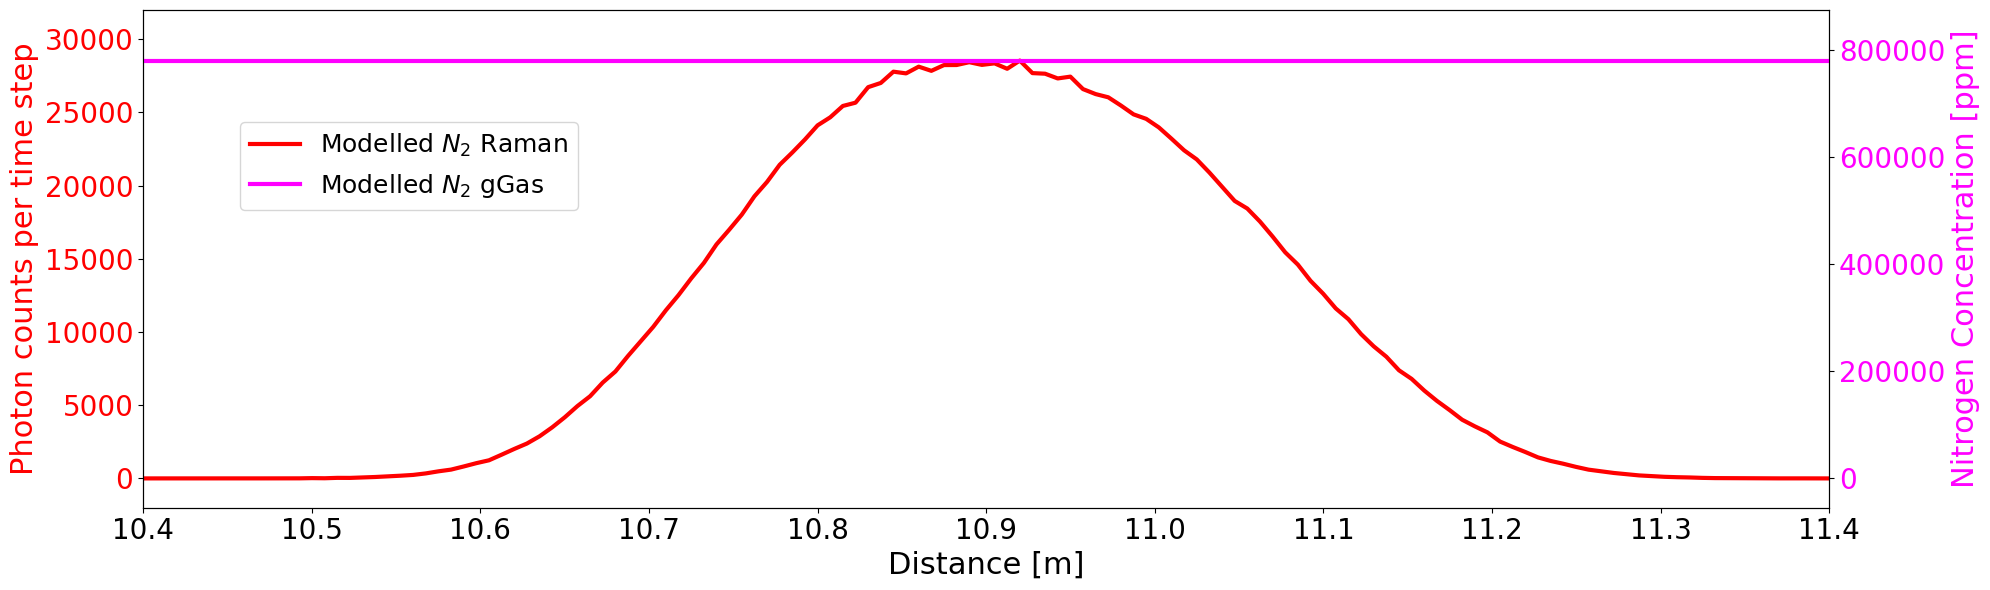

In [ ]:
# --------------------------
# Plot TCSPC result vs gas cloud
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $N_2$ Raman & Gas Concentration - Raman Pump @" + f"{Pump_Lambda:.1f} nm, "
#         + "Stokes @" + f"{N2_Raman_wavelength:.1f} nm", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per time step', color='red', fontsize=22)
ax1.plot(distance_z, N2_signal_spread, color='red', linewidth=3, label=f"Modelled $N_2$ Raman")
ax1.set_ylim(-2000, 32000)  # set y-axis limits
ax1.set_yticks(np.arange(0, 32000, 5000))  # set y-tick marks
ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Nitrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.plot(distance_z, Gas_conc_percent_N2*1e4, color='magenta', linewidth=3, label=f"Modelled $N_2$ gas")
ax2.set_ylim(-55000, 875000)  # set y-limits
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.05, 0.8), fontsize=18)
plt.tight_layout()
plt.show()


# --------------------------
# Plot TCSPC result vs gas cloud (Zoomed in to 10.4–11.4 m)
# --------------------------
fig, ax1 = plt.subplots(figsize = (20, 6))
#plt.title(r"Modelled $N_2$ Raman and Gas Concentration (Zoomed in to 10.4–11.4 m)", fontsize=26, pad=15)

ax1.set_xlabel('Distance [m]', fontsize=22)
ax1.set_ylabel('Photon counts per time step', color='red', fontsize=22)
ax1.set_xlim(10.4, 11.4)  # set x-axis limits
ax1.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax1.set_ylim(-2000, 32000)  # set y-axis limits
ax1.set_yticks(np.arange(0, 32000, 5000))  # set y-tick marks
ax1.plot(distance_z, N2_signal_spread, color='red', linewidth=3, label=f"Modelled $N_2$ Raman")
ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Nitrogen Concentration [ppm]', color='magenta', fontsize=22)
ax2.set_xlim(10.4, 11.4)  # set x-axis limits
ax2.set_xticks(np.arange(10.4, 11.5, 0.1))  # set x-tick marks
ax2.set_ylim(-55000, 875000)  # set y-limits
ax2.plot(distance_z, Gas_conc_percent_N2*1e4, color='magenta', linewidth=3, label=f"Modelled $N_2$ gGas")
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.05, 0.8), fontsize=18)
plt.tight_layout()
plt.show()